In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
import networkx as nx 
import matplotlib.pyplot as plt
import itertools as it
import seaborn as sns
import pickle
import time
import datetime
import statistics
import sklearn as sk
from sklearn.linear_model import LinearRegression as LinReg
import dateutil.parser as dp


plt.rcParams["figure.figsize"] = (16,9)
!pip install pandas==1.4.1
!pip install EoN
pd.__version__
import EoN


ERROR: Could not find a version that satisfies the requirement pandas==1.4.1 (from versions: 0.1, 0.2, 0.3.0, 0.4.0, 0.4.1, 0.4.2, 0.4.3, 0.5.0, 0.6.0, 0.6.1, 0.7.0, 0.7.1, 0.7.2, 0.7.3, 0.8.0, 0.8.1, 0.9.0, 0.9.1, 0.10.0, 0.10.1, 0.11.0, 0.12.0, 0.13.0, 0.13.1, 0.14.0, 0.14.1, 0.15.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.16.2, 0.17.0, 0.17.1, 0.18.0, 0.18.1, 0.19.0, 0.19.1, 0.19.2, 0.20.0, 0.20.1, 0.20.2, 0.20.3, 0.21.0, 0.21.1, 0.22.0, 0.23.0, 0.23.1, 0.23.2, 0.23.3, 0.23.4, 0.24.0, 0.24.1, 0.24.2, 0.25.0, 0.25.1, 0.25.2, 0.25.3, 1.0.0, 1.0.1, 1.0.2, 1.0.3, 1.0.4, 1.0.5, 1.1.0, 1.1.1, 1.1.2, 1.1.3, 1.1.4, 1.1.5, 1.2.0, 1.2.1, 1.2.2, 1.2.3, 1.2.4, 1.2.5, 1.3.0, 1.3.1, 1.3.2, 1.3.3, 1.3.4, 1.3.5)
ERROR: No matching distribution found for pandas==1.4.1


In [ ]:
def creategraphRSSI(df, cond):
    G = nx.Graph()
    tmp = dict()
    divider = "$%&"
    for i, r in df.iterrows():
        scanner = str(r['scanner'])
        advertiser = str(r['advertiser'])
        tmp[scanner+divider+advertiser] = list() 
    for index, row in df.iterrows():
        s = str(row['scanner'])
        a = str(row['advertiser'])
        #esiste già
        if s+divider+a in tmp:
            l = tmp[s+divider+a]
            l.append(int(row['rssi']))
            tmp[s+divider+a]=l 

    for key in tmp:
        k = key.split(divider)
        s1 = k[0]
        s2 = k[1]
        l1 = list()
        l2 = list()
        x1 = False
        x2 = False
        
        if s1+divider+s2 in tmp:
          l1 = tmp[s1+divider+s2]
          x1 = True
        if s2+divider+s1 in tmp:
          l2 = tmp[s2+divider+s1]
          x2 = True
        

        l3 = l1 + l2

        if len(l3)!=0:
            m = statistics.mean(l3)
            G.add_edge(s1, s2, weight=round(m, 2))
        
        if x1:
          tmp[s1+divider+s2] = list()
        if x2:
          tmp[s2+divider+s1] = list()
    
    fig = plt.figure(figsize=(15, 10))
    pos=nx.spring_layout(G,seed=50) # pos = nx.nx_agraph.graphviz_layout(G)
    widths = nx.get_edge_attributes(G, 'weight')
    nodelist = G.nodes()
    x = list(widths.values())
    if len(x) == 0:
        return
    m = max(x)
    
    nx.draw_networkx_nodes(G,pos,
        nodelist=nodelist,
        node_size=1500,
        node_color='grey',
        alpha=0.7)
    nx.draw_networkx_edges(G,pos,
        edgelist = widths.keys(),
        width=list(map(lambda number: number * 18 / m, x)),
        edge_color='lightblue',
        alpha=0.6)
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    nx.draw_networkx_labels(G, pos=pos)
    if cond:
        ax = plt.axes()
        ax.set_facecolor("yellow")
    plt.show()
    t, S, I, R = EoN.fast_SIR(G,0.2, 0.11)
    plt.plot(t,S,color='red',marker='o')
    plt.title("Variazione suscettibili nel tempo")
    plt.xlabel('Iterazione')
    plt.ylabel('Soggetti suscettibili')
    plt.show()
    plt.plot(t,I,color='orange',marker='o')
    plt.title("Variazione infetti nel tempo")
    plt.xlabel('Iterazione')
    plt.ylabel('Soggetti infetti')
    plt.show()
    plt.plot(t,R,color='green',marker='o')
    plt.title("Variazione guariti nel tempo")
    plt.xlabel('Iterazione')
    plt.ylabel('Soggetti guariti')
    plt.show()


In [ ]:
def creategraph(df, cond):
    G = nx.Graph()
    tmp = dict()
    divider = "$%&"

    # tmp = set() # set, come una lista ma non ripetuta
    # scan = df.scanner.unique() # lista non ripetuta di tutti gli scanner
    # for id in scan : 
    #   adv = df[df.scanner==id].unique() # lista non ripetuta di tutti gli advertiser per un scanner
    #   for ad in adv: tmp.add((id, ad)) # aggiungiamo una tupla (a,b), la tupla è un elemento statico
    # Questo codice ti darà un set non ripetuto di tuple, puoi poi convertire tutto in liste di liste...
    # approccio migliore è quello di usare network per aggiungere direttamente i pesi,
    # ad esempio: 
    # G = nx.Graph()
    # scan = df.scanner.unique() # lista non ripetuta di tutti gli scanner
    # for id in scan : 
    #   adv = df[df.scanner==id].unique() # lista non ripetuta di tutti gli advertiser per un scanner
    #   for ad in adv: 
    #     if G.has_edge(id,ad): # check se il link esiste. Va controllato se fa sia a-b che b-a (direct, indirect)
    #       G[id][ad]['weight'] += 1 # aumento di 1 il peso
    #     else:
    #       G.add_edge(id,ad,weight=1) # creo il noto

    for index, row in df.iterrows():
        scanner = str(row['scanner'])
        advertiser = str(row['advertiser'])
        #esiste già
        tmp[scanner+divider+advertiser] = 0

    for index, row in df.iterrows():
        scanner = str(row['scanner'])
        advertiser = str(row['advertiser'])
        #esiste già
        if scanner+divider+advertiser in tmp:
            #count = tmp[scanner+divider+advertiser]
            tmp[scanner+divider+advertiser]+=1
        
            
    for key in tmp:
        k = key.split(divider)
        s1 = k[0]
        s2 = k[1]
        x1 = False
        x2 = False
        c1 = 0
        c2 = 0
        count = 0
        
        if s1+divider+s2 in tmp:
          c1 = tmp[s1+divider+s2]
          x1 = True
        if s2+divider+s1 in tmp:
          c2 = tmp[s2+divider+s1]
          x2 = True

        if c1+c2 != 0:
          G.add_edge(s1, s2, weight=c1+c2)
        
        if x1:
          tmp[s1+divider+s2] = 0
        if x2:
          tmp[s2+divider+s1] = 0
    
    fig = plt.figure(figsize=(15, 10))
    pos=nx.spring_layout(G,seed=50) # pos = nx.nx_agraph.graphviz_layout(G)
    widths = nx.get_edge_attributes(G, 'weight')
    nodelist = G.nodes()
    x = list(widths.values())
    if len(x) == 0:
      return
    m = max(x)
    
    nx.draw_networkx_nodes(G,pos,
                       nodelist=nodelist,
                       node_size=1500,
                       node_color='grey',
                       alpha=0.7)
    nx.draw_networkx_edges(G,pos,
                       edgelist = widths.keys(),
                       width=list(map(lambda number: number * 18 / m, x)),
                       edge_color='lightblue',
                       alpha=0.6)
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    nx.draw_networkx_labels(G, pos=pos)
    if cond:
      ax = plt.axes()
      ax.set_facecolor("yellow")
    plt.show()

In [ ]:
def create_time_networks(d, cond):
    #prendo l'elemento zero
    splits = np.array_split(d, 12)
    for split in splits:
        creategraph(split, cond)

In [ ]:
def create_rssi_networks(d, cond):
    #prendo l'elemento zero
    splits = np.array_split(d, 12)
    for split in splits:
        creategraphRSSI(split, cond)

In [ ]:
def struttura(dati):
  conn = dati
  conn['time'] =  pd.to_datetime(conn['time'],utc=True)
  conn['type'] = np.where(conn.time.dt.time > datetime.time(10, 29, 0), 'collo', 'tasca')
  conn = conn.sort_values(by="time")
  scan = conn.scanner.unique()
  adv = conn.advertiser.unique()
  print(scan)
  print(adv)
  conn.head()

In [ ]:
def unixtimestamp(d: str):
    tm1 = parsed_t = dp.parse(d)
    a = time.mktime(tm1.timetuple())
    return int(a)

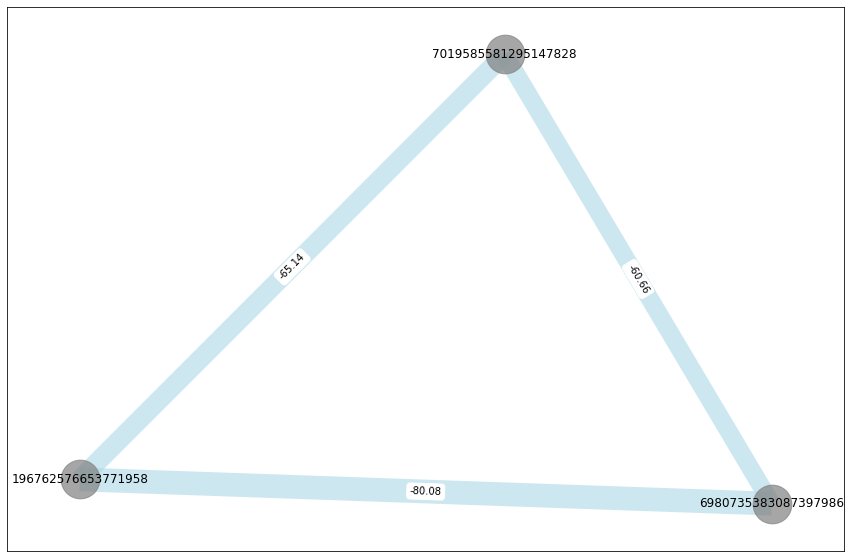

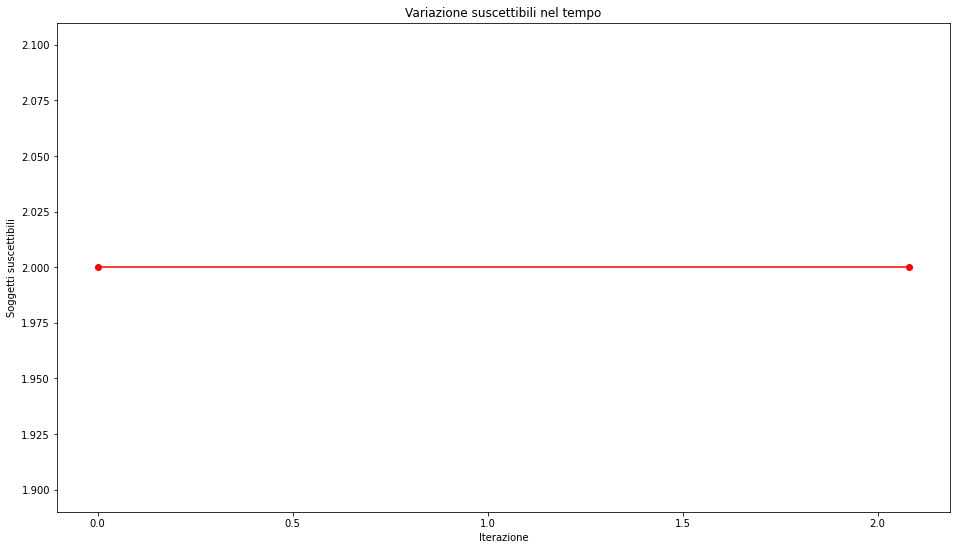

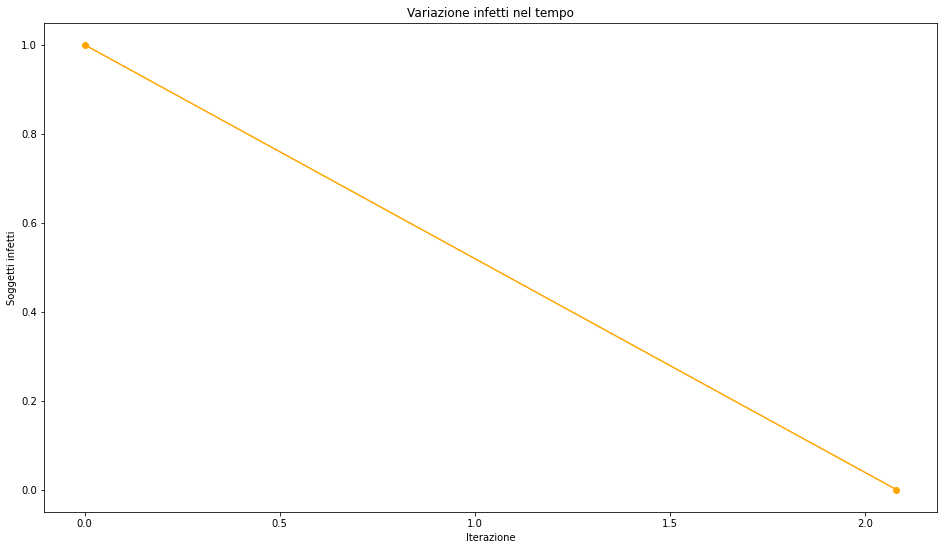

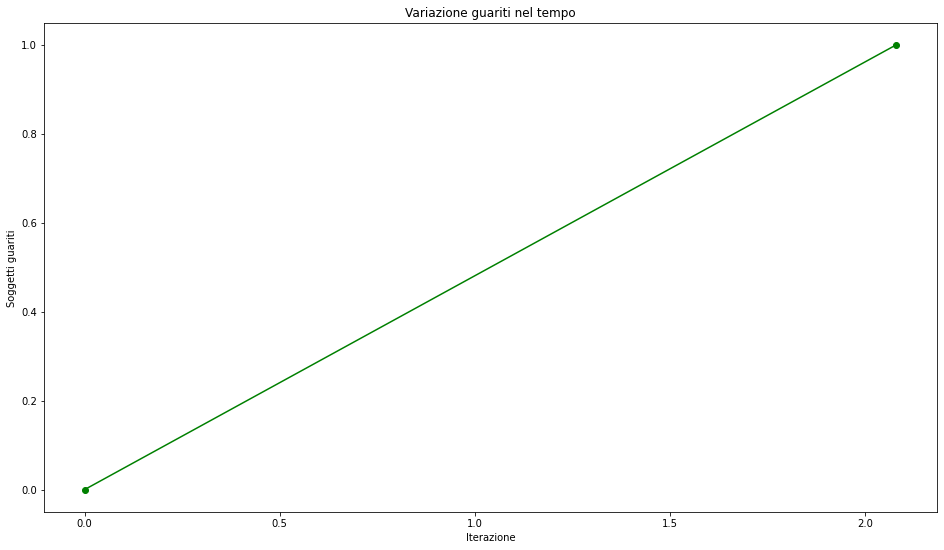

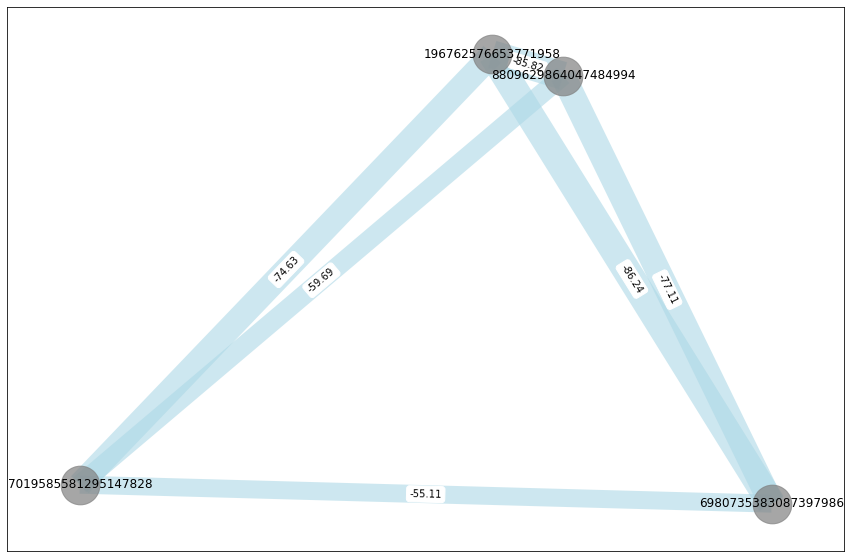

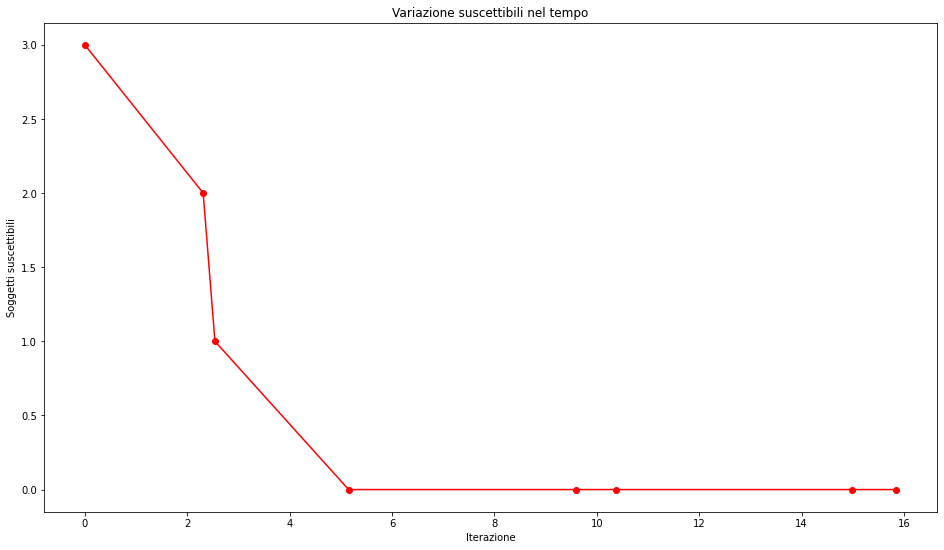

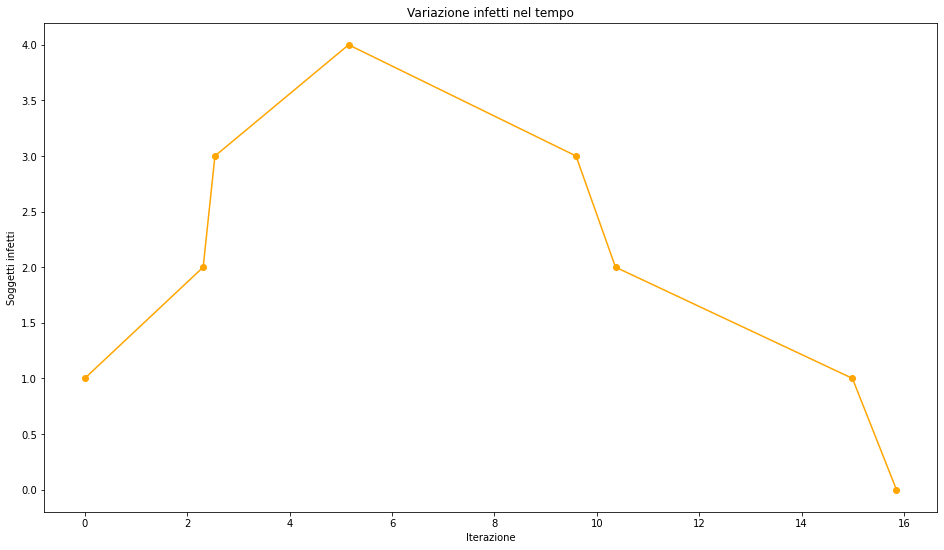

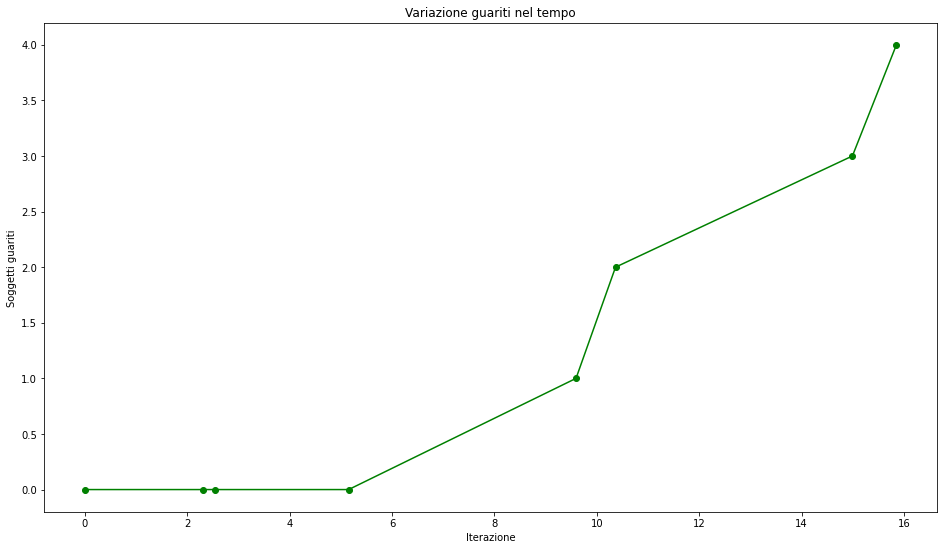

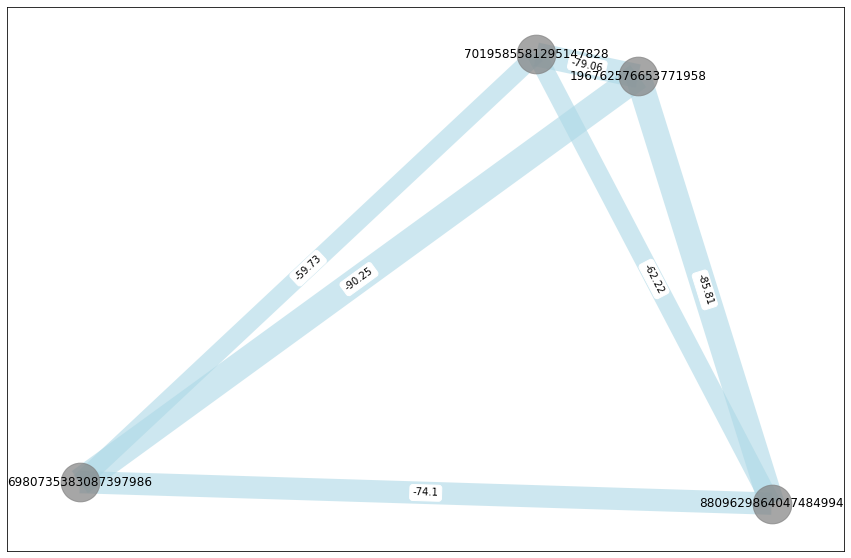

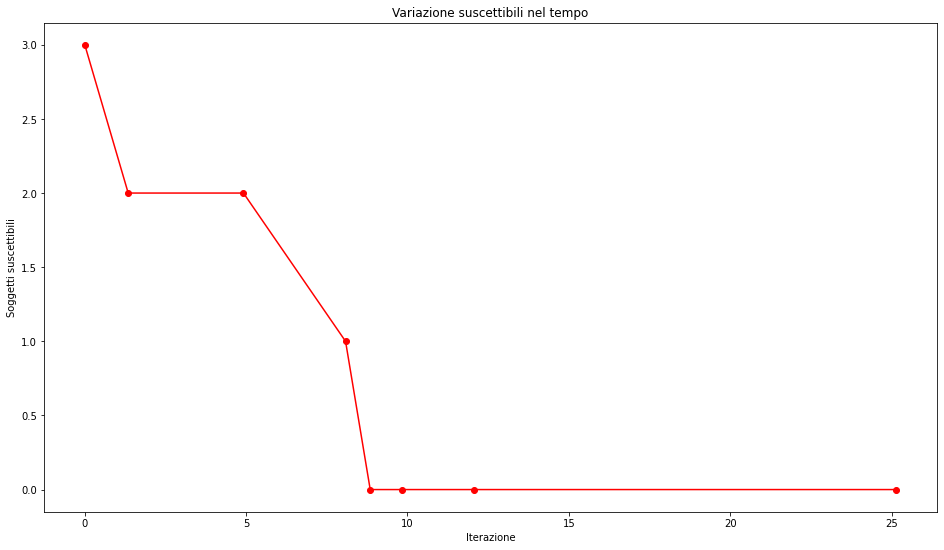

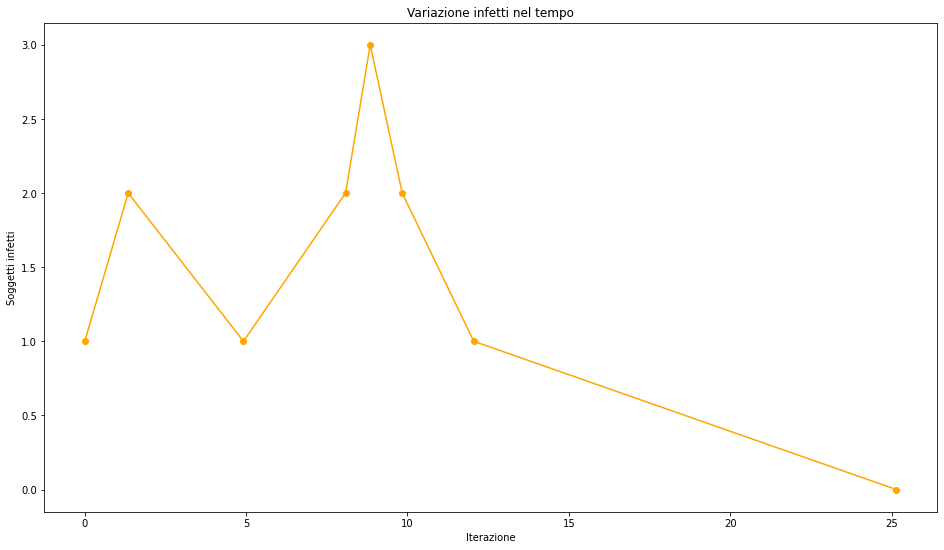

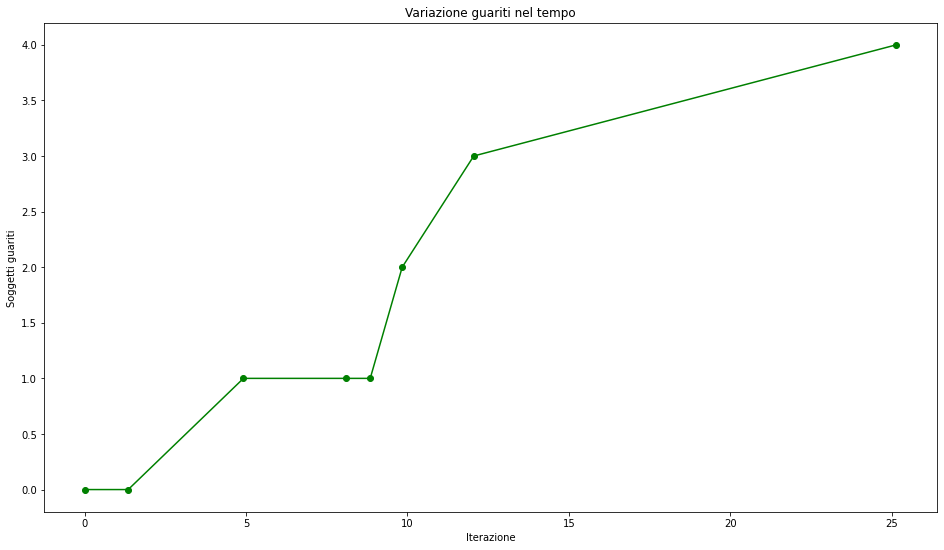

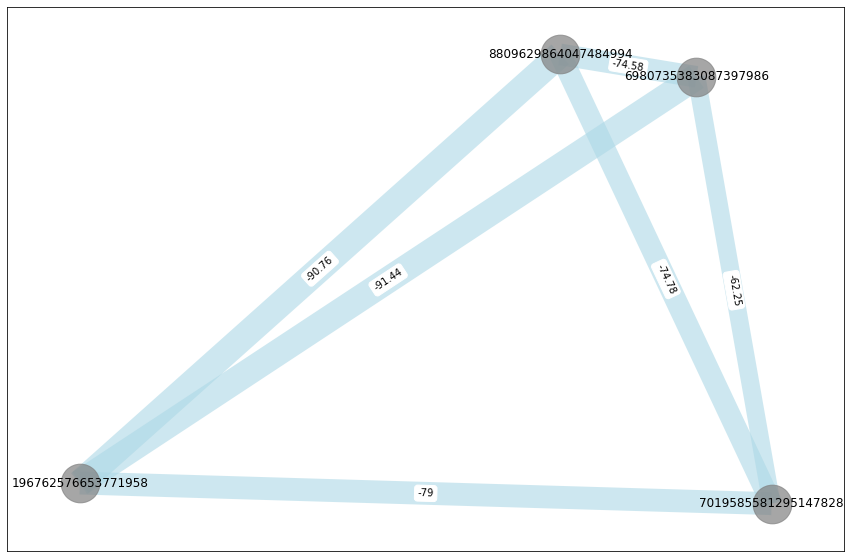

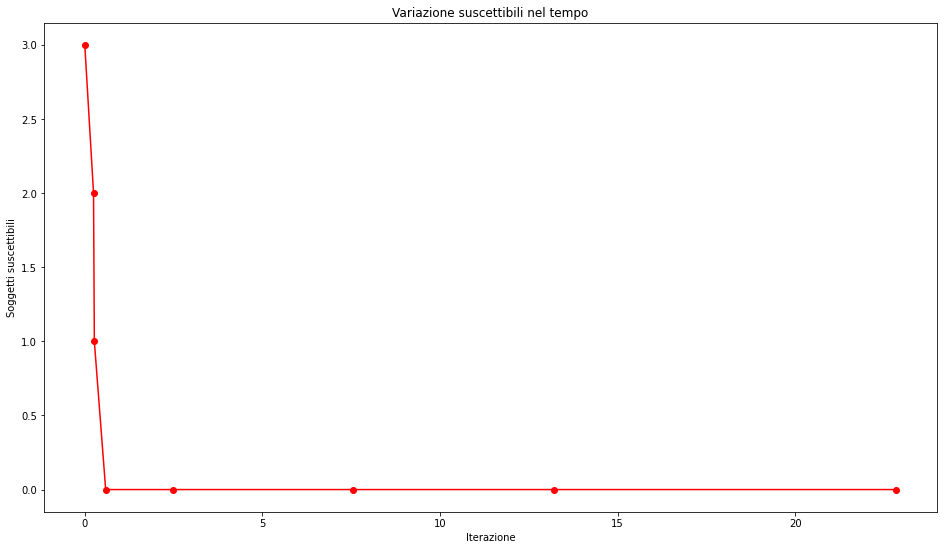

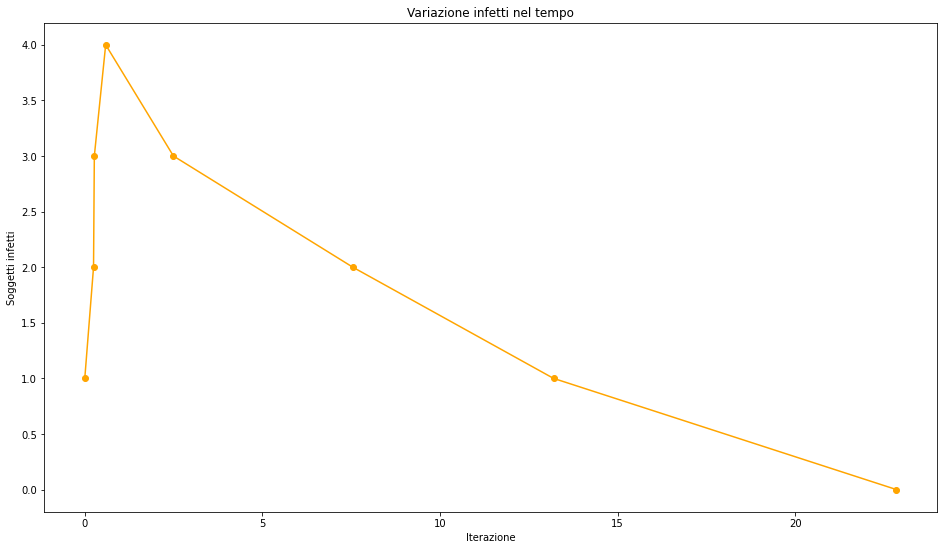

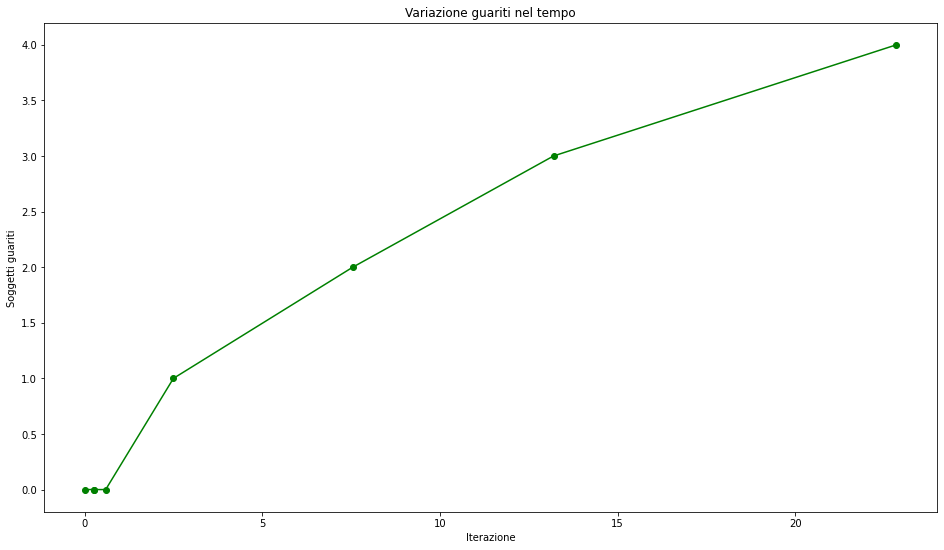

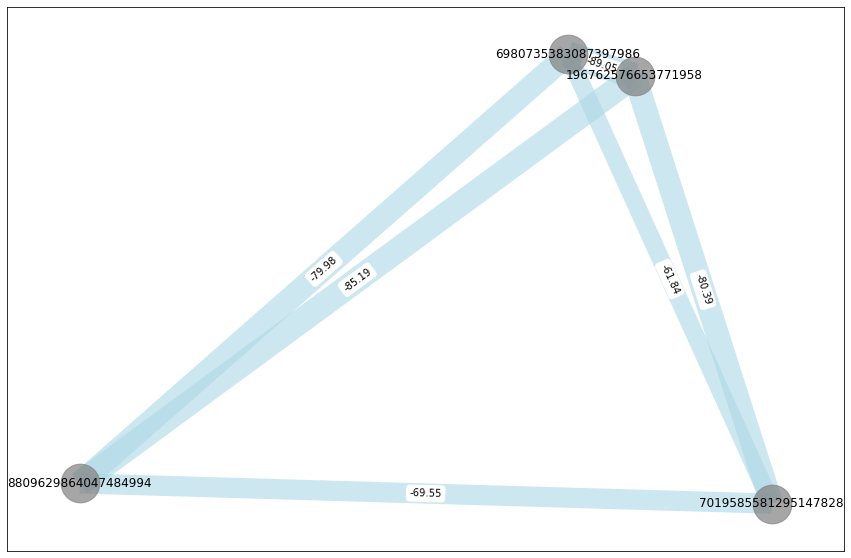

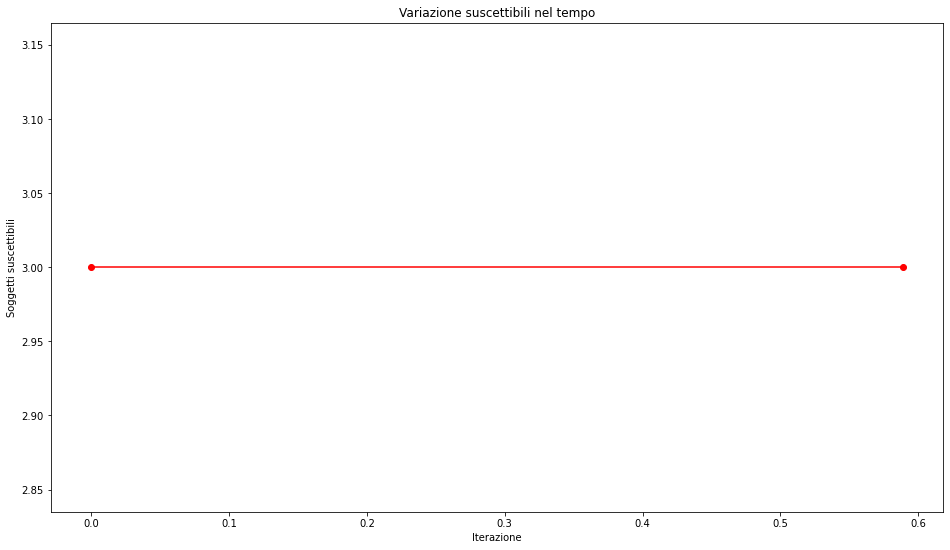

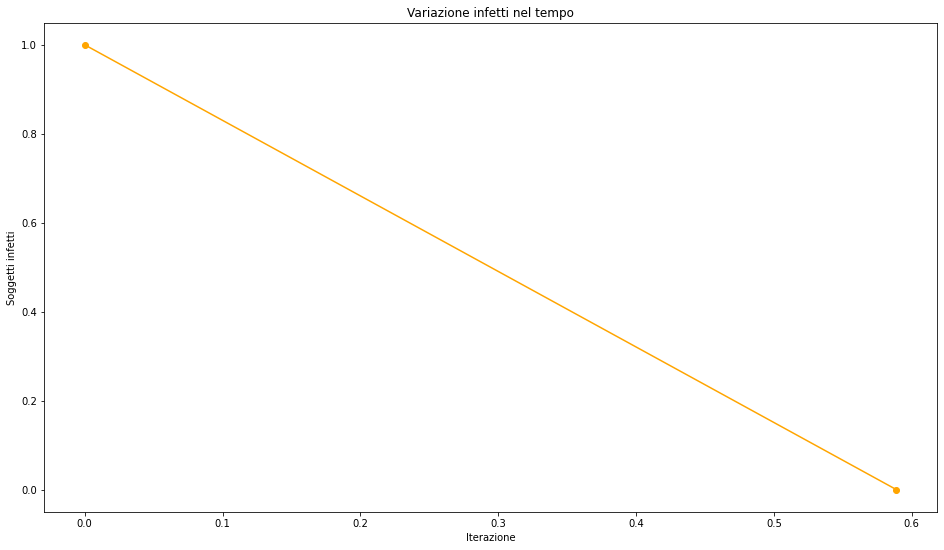

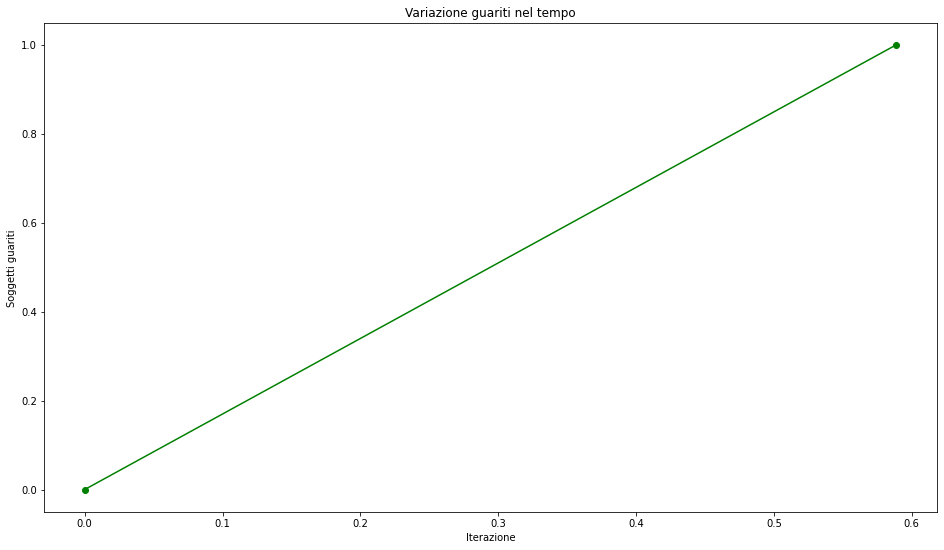

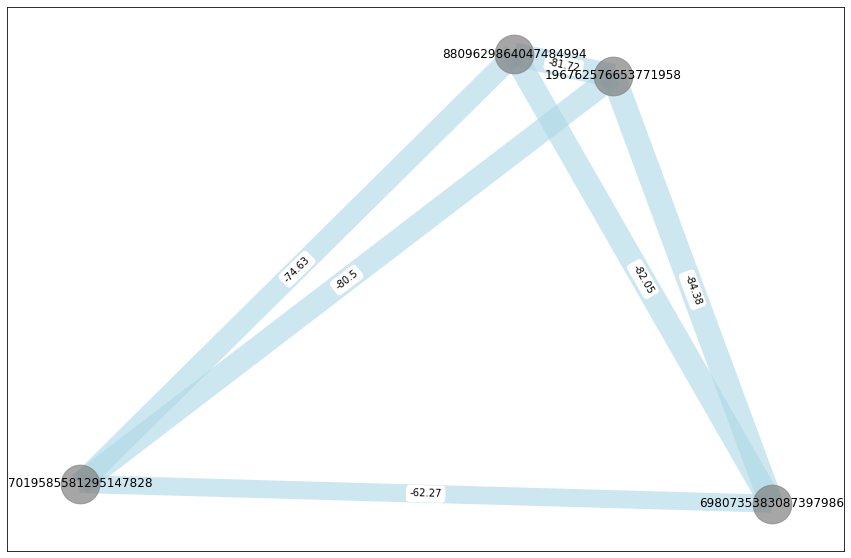

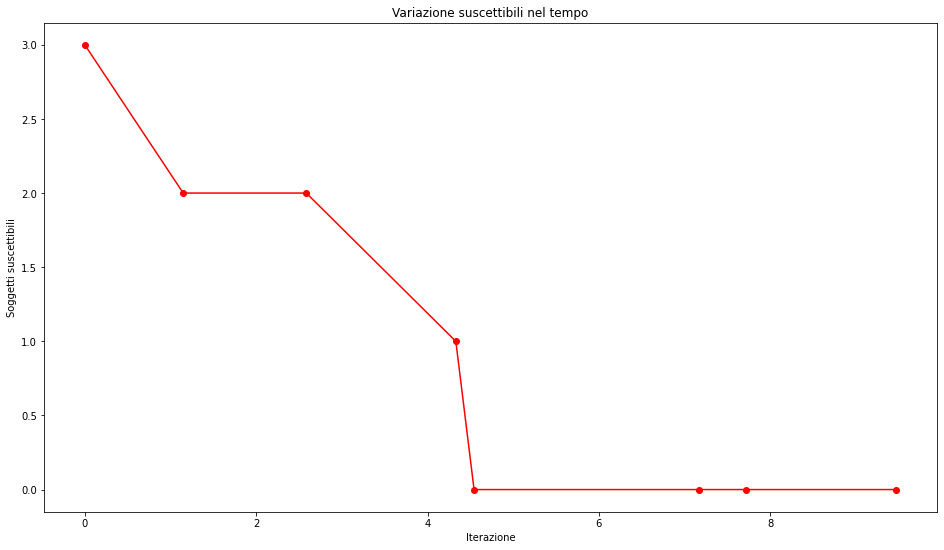

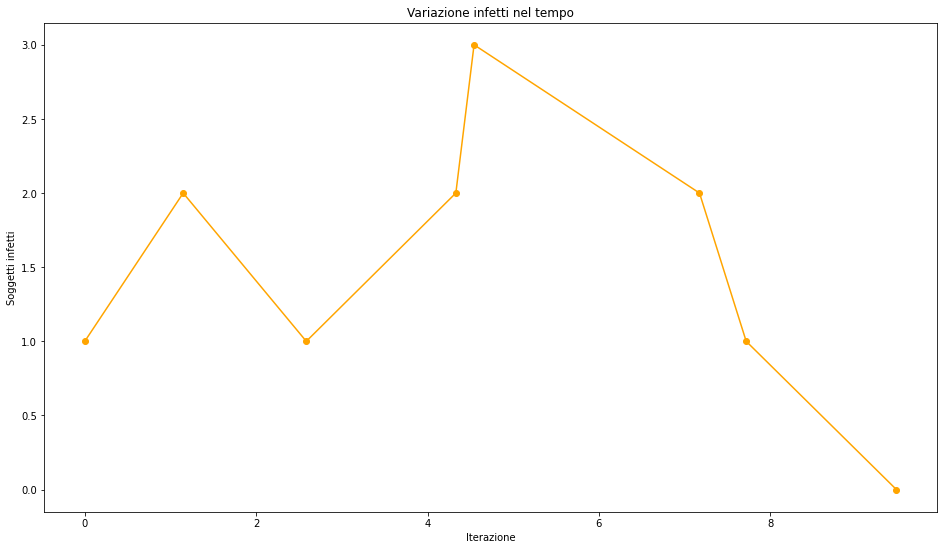

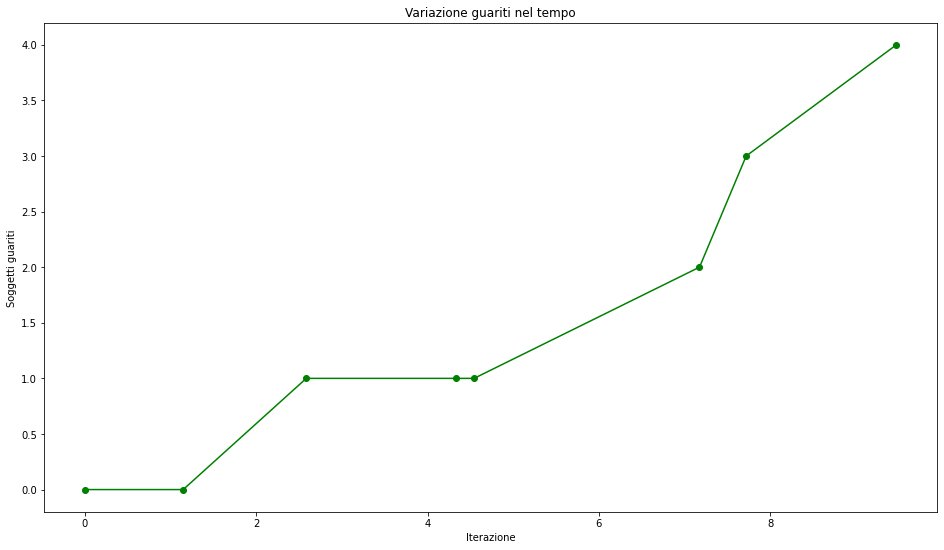

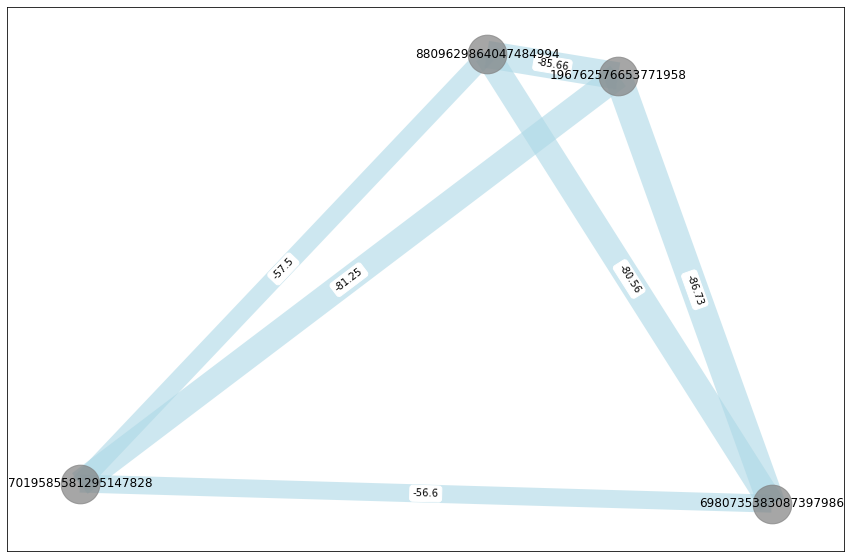

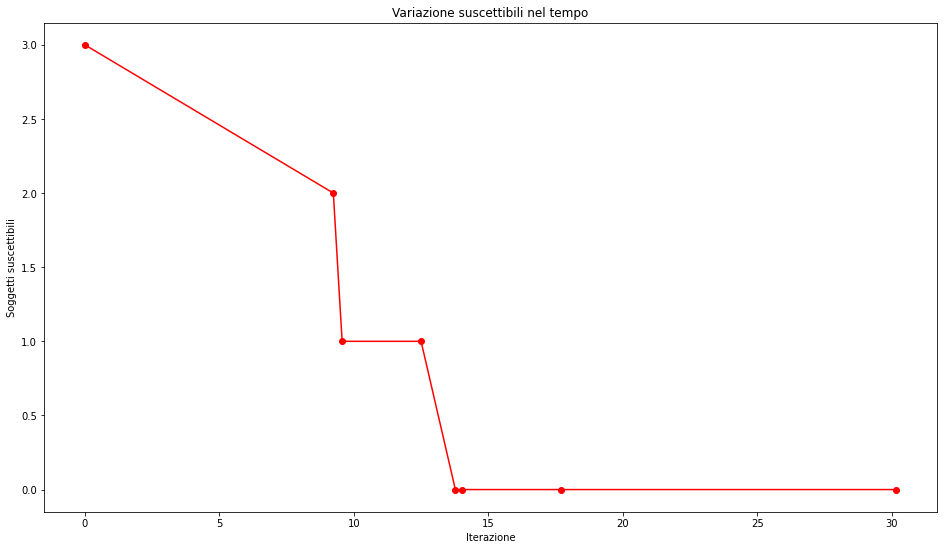

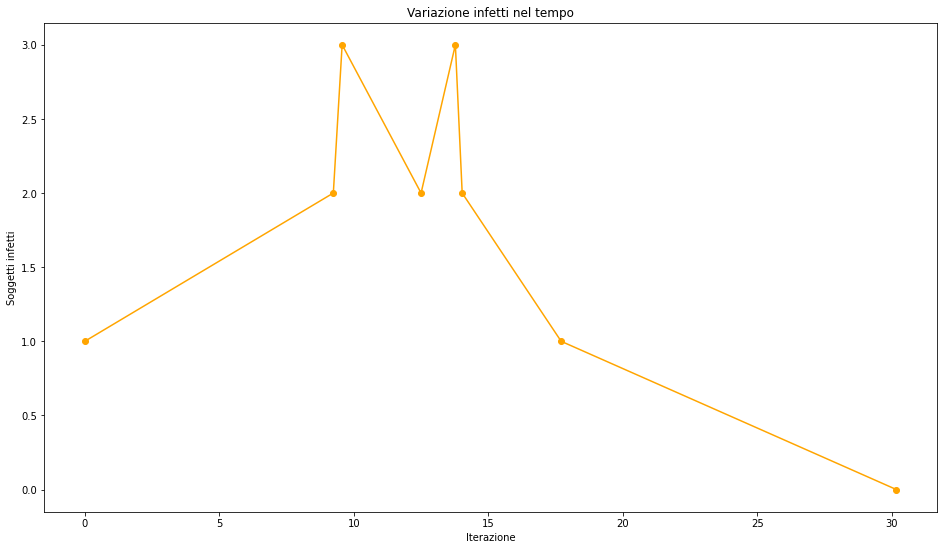

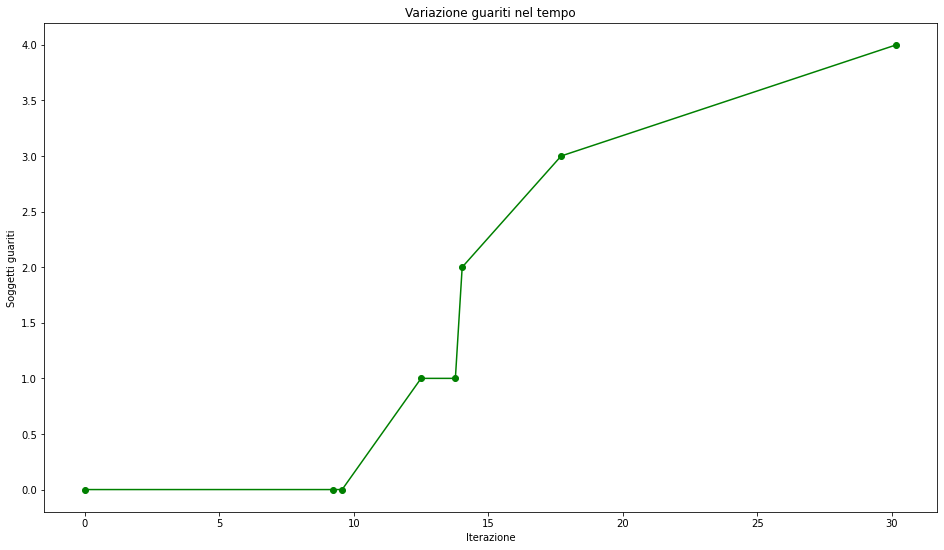

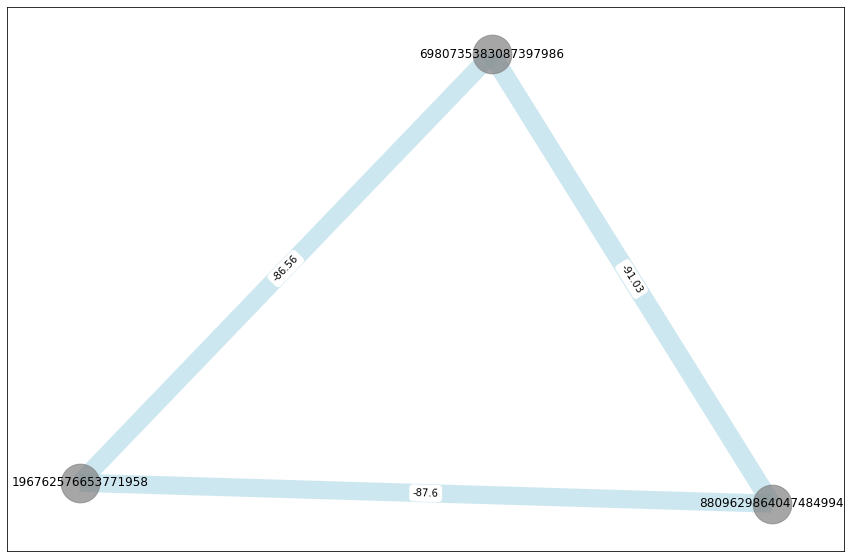

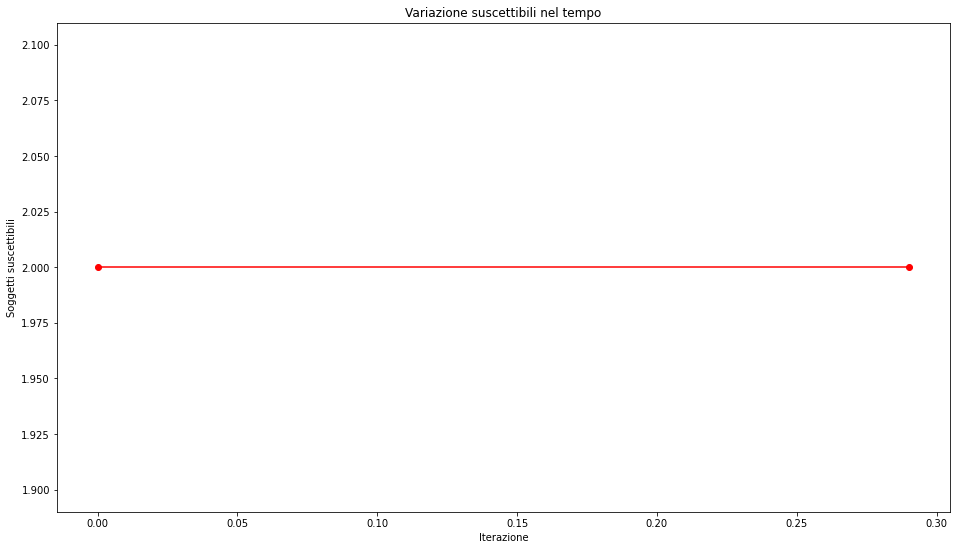

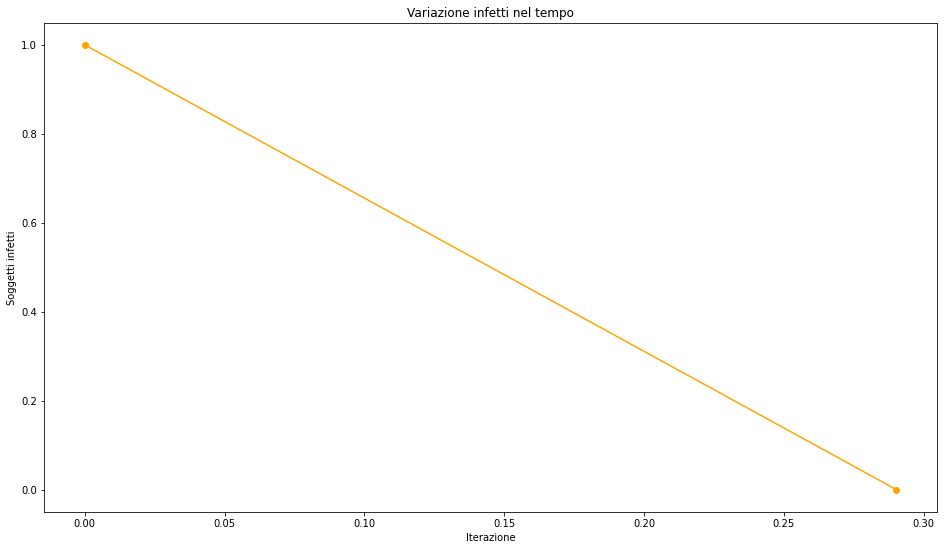

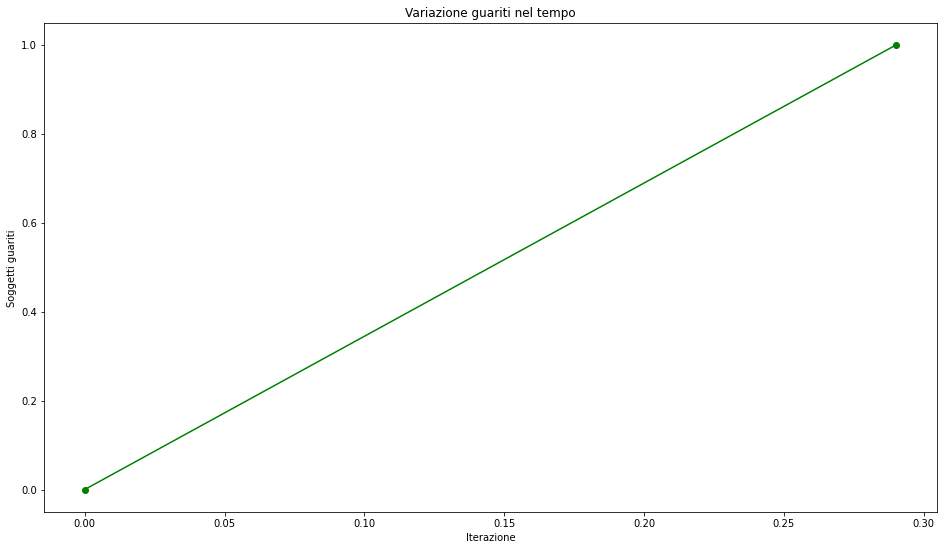

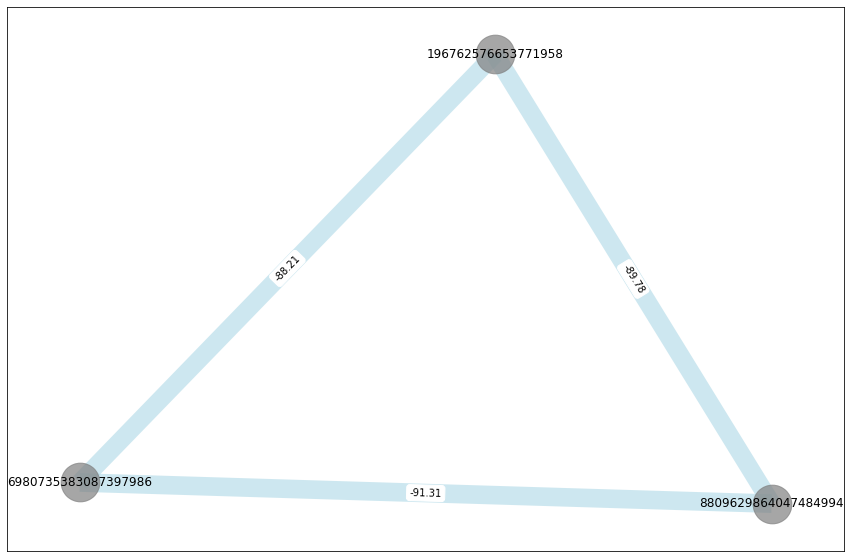

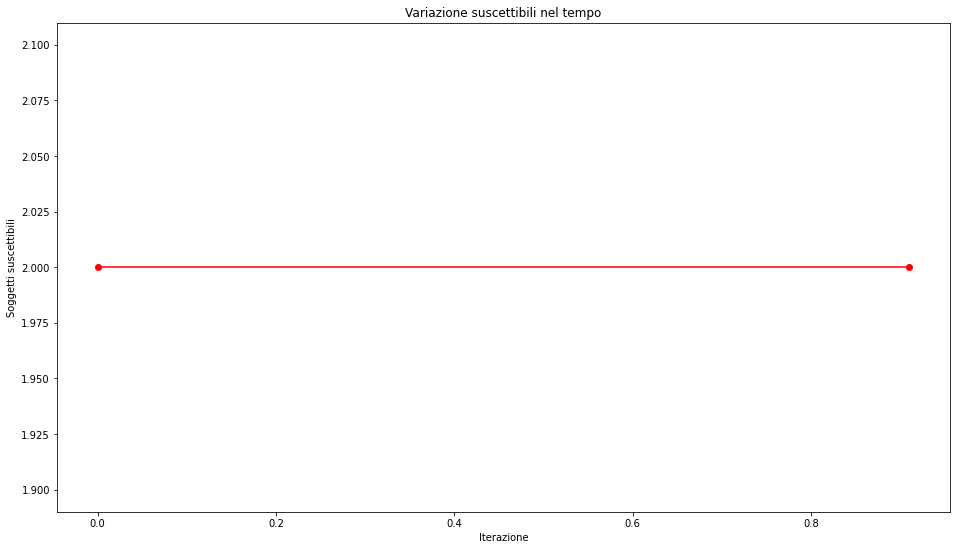

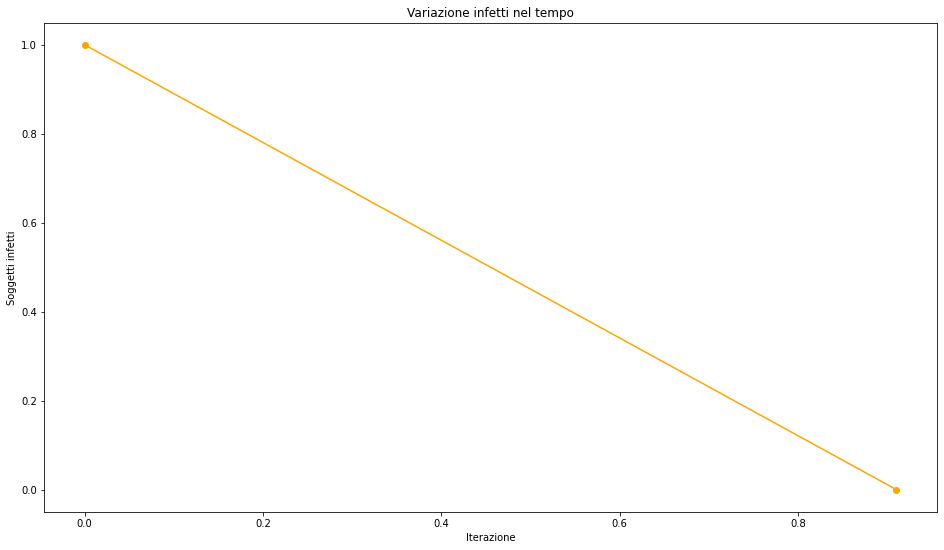

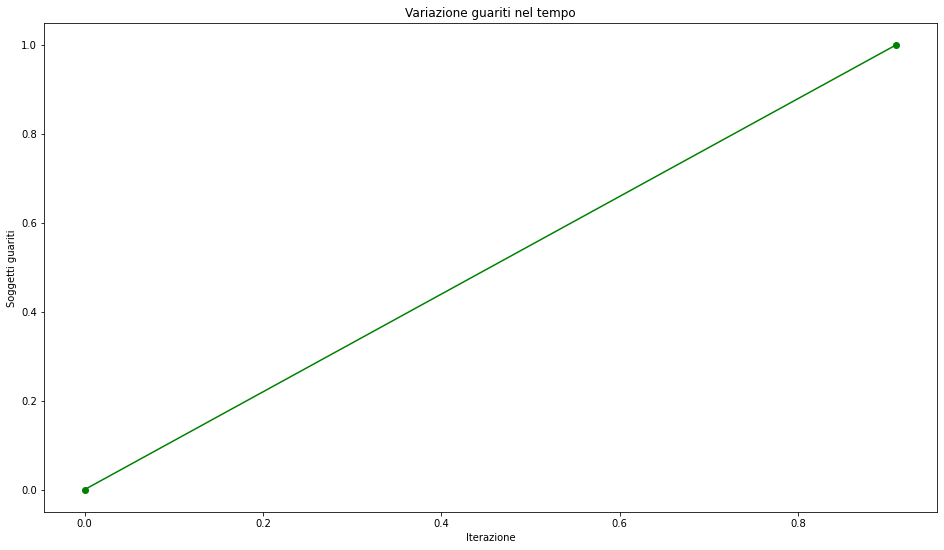

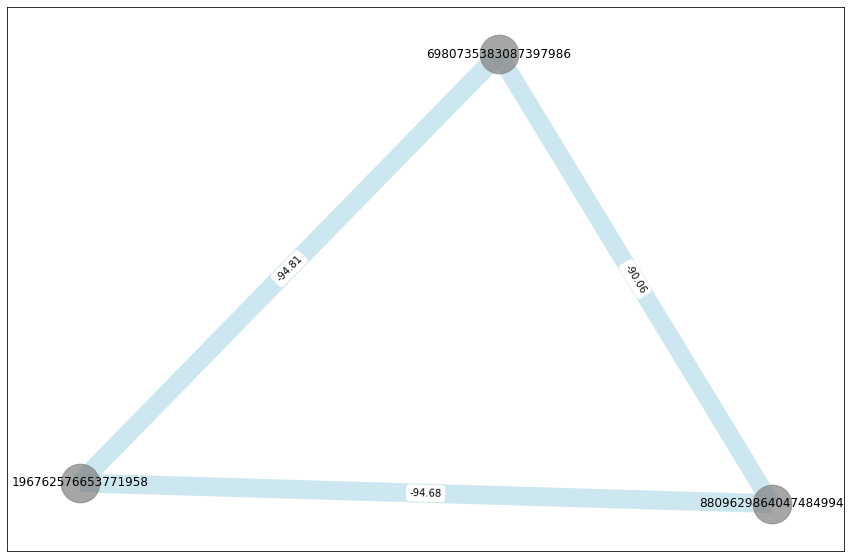

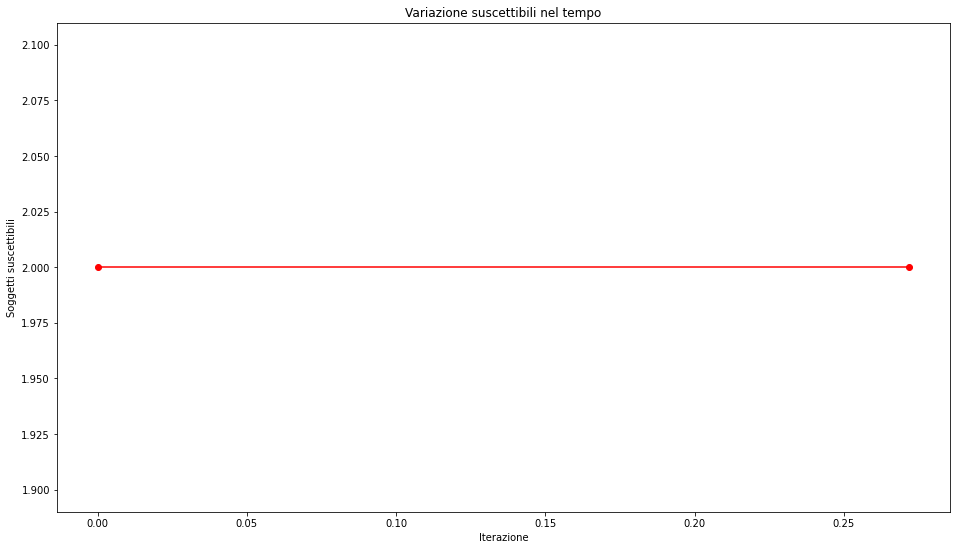

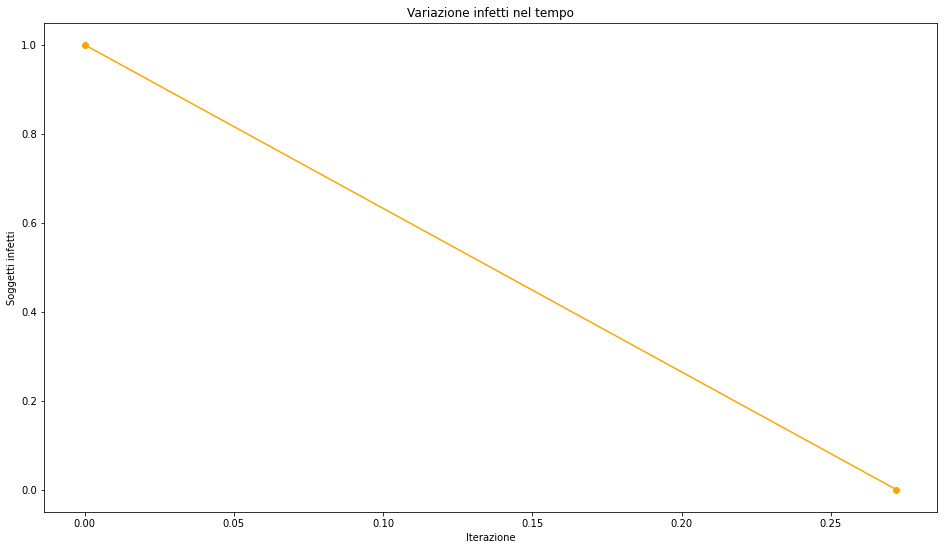

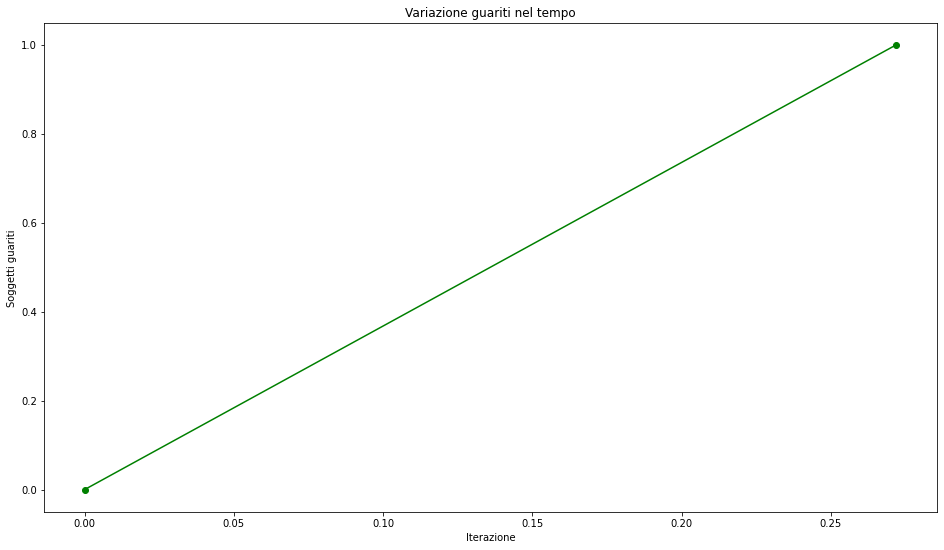

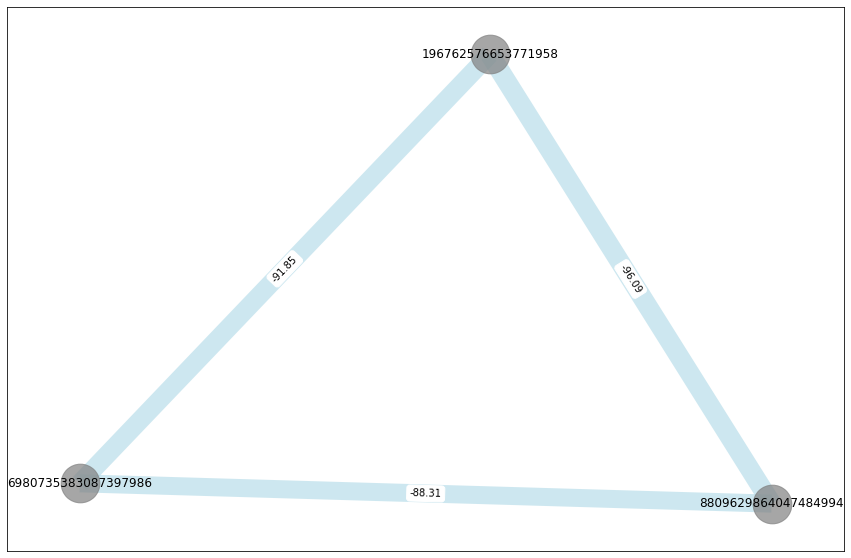

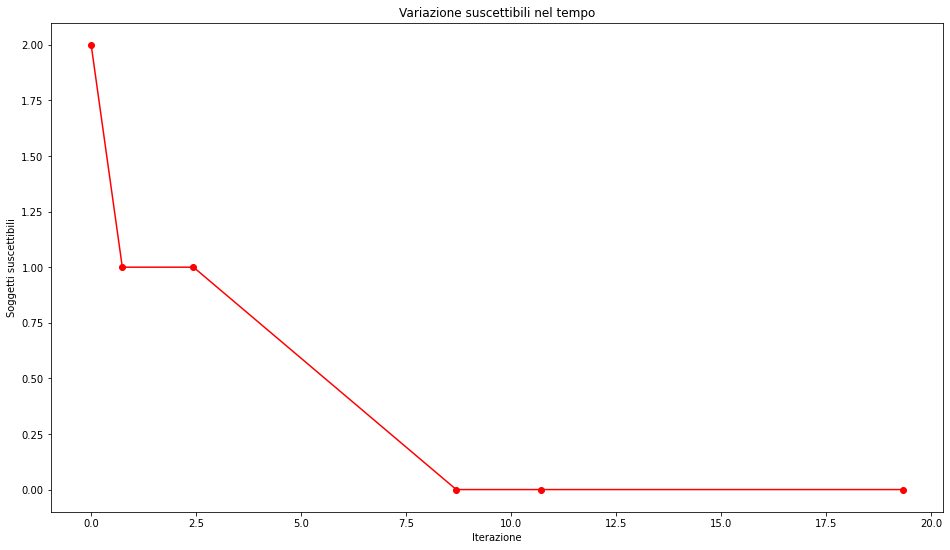

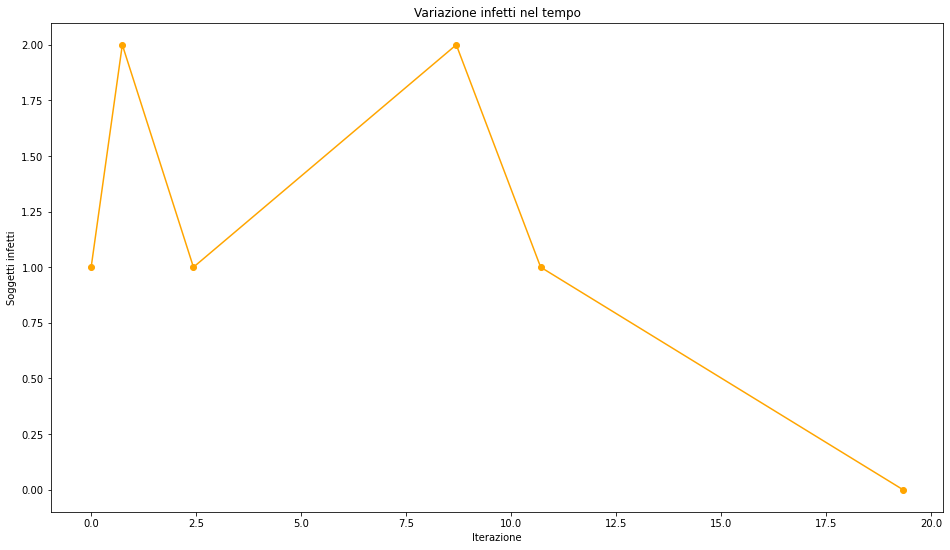

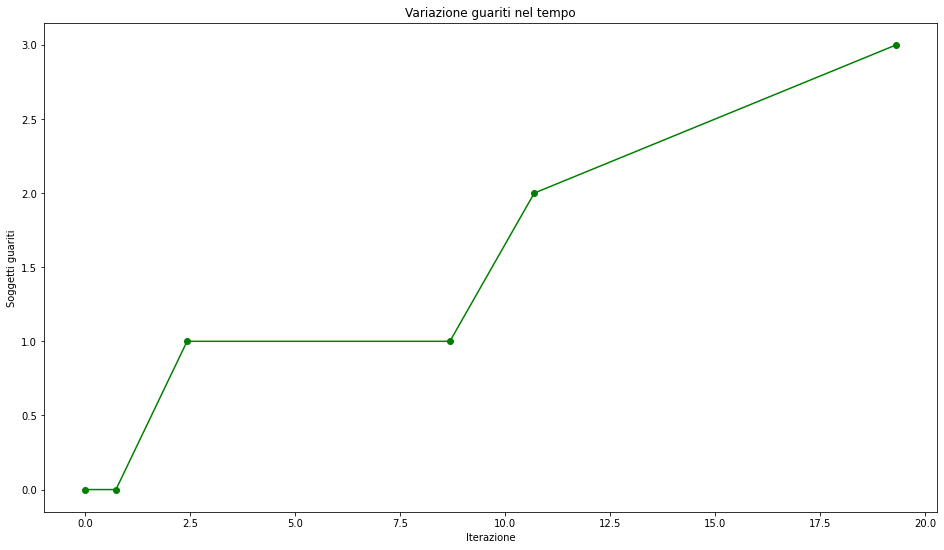

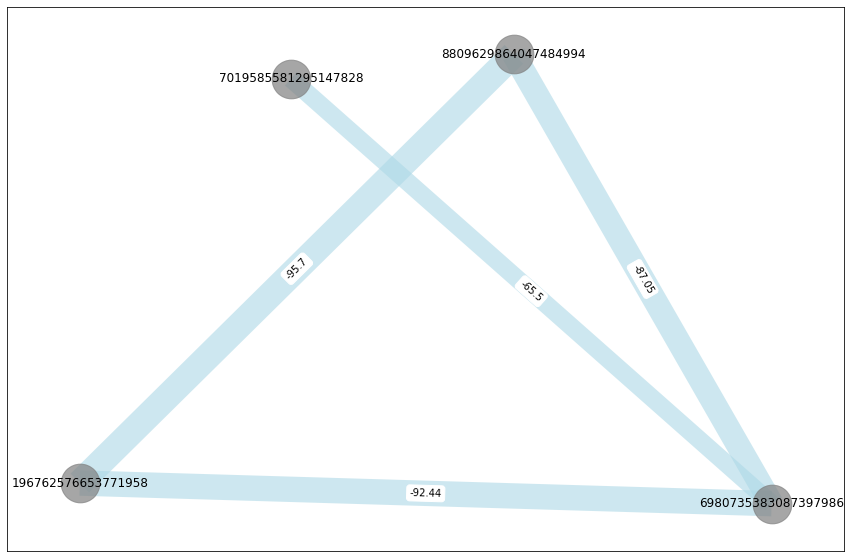

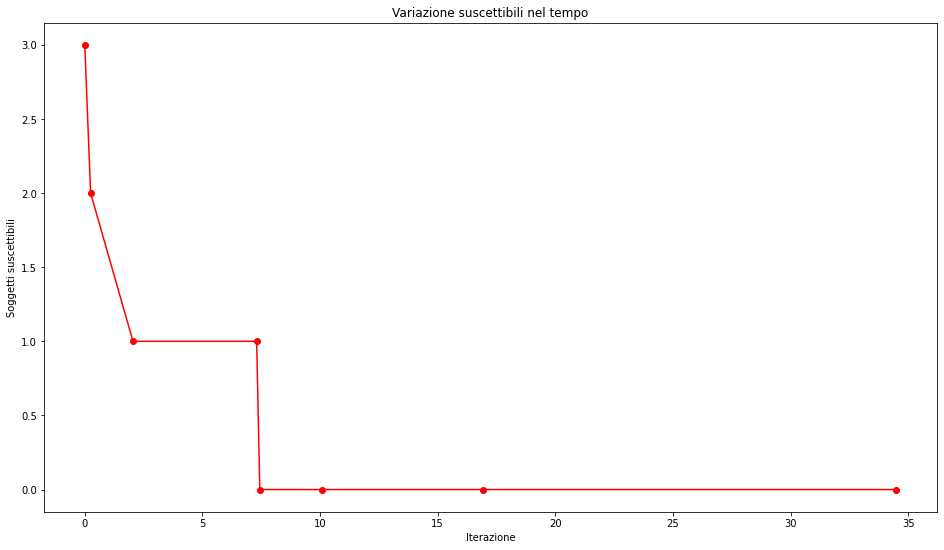

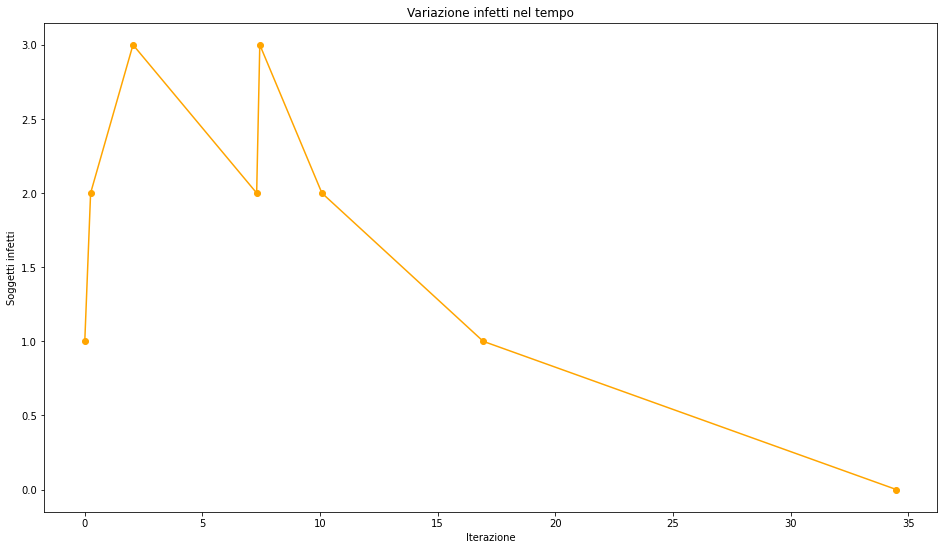

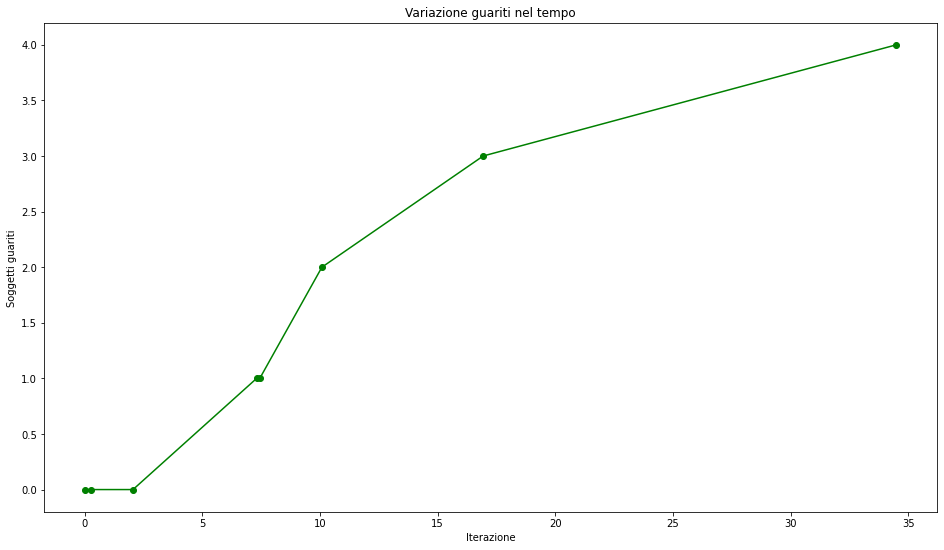

In [ ]:
np.set_printoptions(suppress=True)
conn = pd.read_csv("/content/drive/MyDrive/Esperimenti/connections_norm_test1.csv")
conn['time'] =  pd.to_datetime(conn['time'],utc=True)
conn['type'] = np.where(conn.time.dt.time > datetime.time(10, 29, 0), 'collo', 'tasca')
tasca, collo = [x for _, x in conn.groupby(conn['type'] == "collo")]
#conn = conn.sort_values(by="time")
df1 = pd.DataFrame(tasca)
df2 = pd.DataFrame(collo)
#df['time'] = df['time'].apply(unixtimestamp)
#struttura(dati)
#create_time_networks(df1, True)
#create_time_networks(df1, False)
#create_rssi_networks(df1, True)
create_rssi_networks(df1, False)
#creategraph(df)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
